Generating sample meteorological data...
Training intra-station models...
Making intra-station predictions...
Training inter-station panel model...
Making inter-station predictions...
Training meta-learner ensemble...
Meta-model coefficients for temperature:
  Intra-station weight: 6.7093
  Inter-station weight: 1.6920
  Intercept: 21.0598
Meta-model coefficients for precipitation:
  Intra-station weight: 1.2286
  Inter-station weight: -0.1805
  Intercept: 1.7227
Meta-model coefficients for humidity:
  Intra-station weight: 12.4252
  Inter-station weight: -5.0601
  Intercept: 60.5293
Meta-model coefficients for sunshine:
  Intra-station weight: 0.5100
  Inter-station weight: 1.5354
  Intercept: 7.1608
Meta-model coefficients for evapotranspiration:
  Intra-station weight: 2.9512
  Inter-station weight: 1.4338
  Intercept: 12.6806
Making ensemble predictions...
Evaluating results...

Evaluation Results:
                         RMSE       MAE        R²
temperature          8.803998  2.3

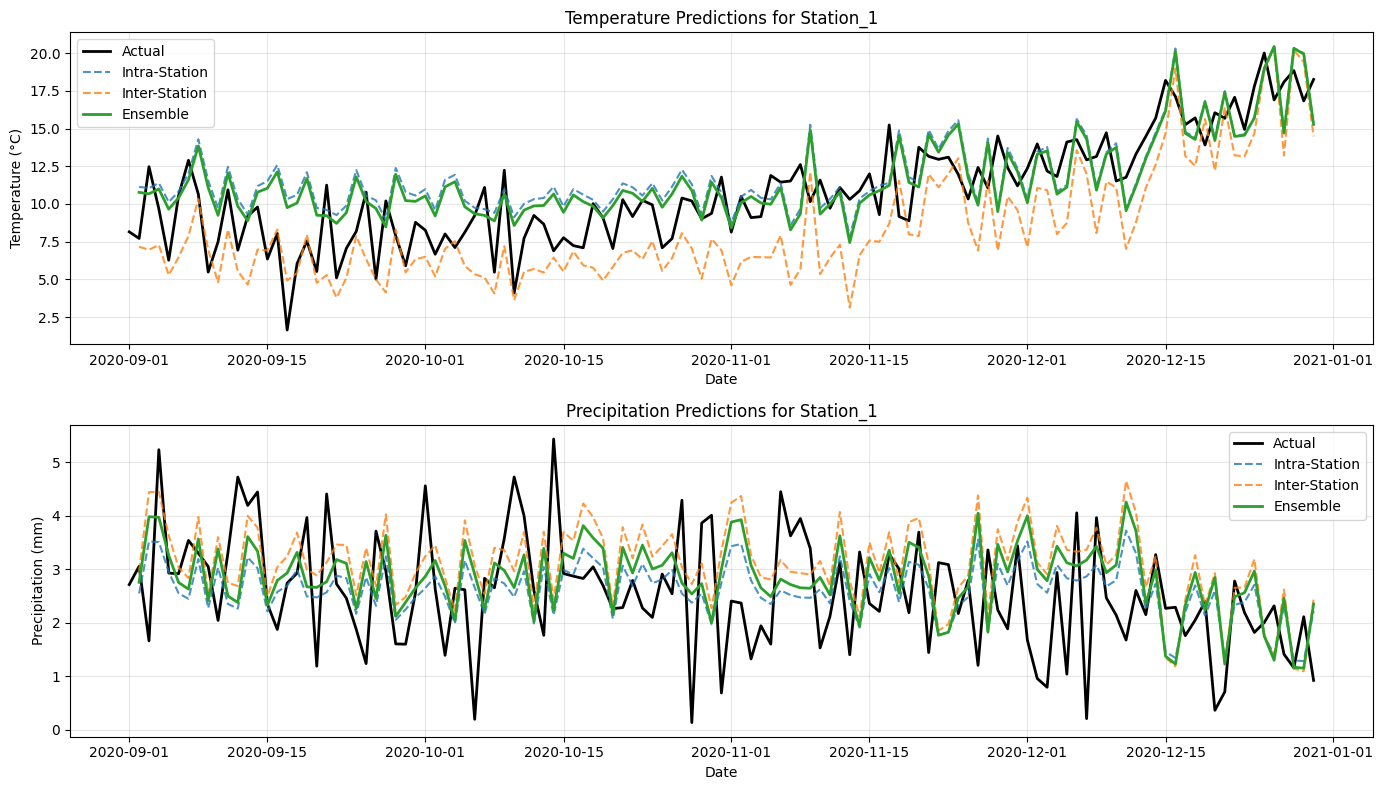

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# 1. Generate synthetic meteorological data for multiple stations
def generate_sample_data(n_stations=10, n_time_periods=365):
    """
    Generate synthetic meteorological data for multiple stations over time
    """
    stations = [f'Station_{i}' for i in range(1, n_stations+1)]
    time_index = pd.date_range('2020-01-01', periods=n_time_periods, freq='D')
    
    # Create empty panel dataset
    panel_data = []
    
    for station in stations:
        # Base patterns with station-specific characteristics
        base_temp = np.random.normal(15, 5)  # Station-specific base temperature
        base_precip = np.random.normal(2, 0.5)  # Station-specific base precipitation
        
        # Generate time series with seasonality and trends
        time_trend = np.linspace(0, 1, n_time_periods) * 0.5  # Slight warming trend
        seasonal_effect = 10 * np.sin(2 * np.pi * np.arange(n_time_periods) / 365)
        
        # Temperature components
        temp_trend = base_temp + time_trend + seasonal_effect
        temperature = temp_trend + np.random.normal(0, 2, n_time_periods)
        
        # Precipitation components (inversely related to temperature)
        precip_trend = base_precip - 0.1 * (temp_trend - base_temp)
        precipitation = np.maximum(0, precip_trend + np.random.normal(0, 1, n_time_periods))
        
        # Other variables with relationships to temperature and precipitation
        humidity = 60 - 0.8 * (temperature - base_temp) + 2 * precipitation + np.random.normal(0, 5, n_time_periods)
        sunshine = 8 - 0.5 * precipitation + np.random.normal(0, 2, n_time_periods)
        evapotranspiration = 0.5 * temperature + 0.3 * sunshine + np.random.normal(0, 1, n_time_periods)
        
        # Create station DataFrame
        station_df = pd.DataFrame({
            'station': station,
            'date': time_index,
            'temperature': temperature,
            'precipitation': precipitation,
            'humidity': humidity,
            'sunshine': sunshine,
            'evapotranspiration': evapotranspiration
        })
        
        # Add spatial coordinates (random but clustered)
        if station.startswith('Station_1') or station.startswith('Station_2'):
            station_df['latitude'] = np.random.normal(40.0, 0.1)
            station_df['longitude'] = np.random.normal(-75.0, 0.1)
            station_df['elevation'] = np.random.normal(100, 20)
        elif station.startswith('Station_3') or station.startswith('Station_4'):
            station_df['latitude'] = np.random.normal(35.0, 0.1)
            station_df['longitude'] = np.random.normal(-80.0, 0.1)
            station_df['elevation'] = np.random.normal(200, 30)
        else:
            station_df['latitude'] = np.random.normal(45.0, 0.2)
            station_df['longitude'] = np.random.normal(-70.0, 0.2)
            station_df['elevation'] = np.random.normal(50, 15)
            
        panel_data.append(station_df)
    
    # Combine all station data
    full_data = pd.concat(panel_data, ignore_index=True)
    
    # Create spatial clusters based on coordinates
    full_data['region'] = 'North'
    full_data.loc[full_data['latitude'] < 37.5, 'region'] = 'South'
    full_data.loc[(full_data['latitude'] >= 37.5) & (full_data['latitude'] < 42.5), 'region'] = 'Central'
    
    return full_data

# 2. Intra-station modeling with multi-output machine learning
class IntraStationModel:
    """Machine learning model for intra-station dependencies"""
    
    def __init__(self, model_type='random_forest'):
        self.model_type = model_type
        self.models = {}  # One model per station
        self.station_features = ['temperature', 'precipitation', 'humidity', 'sunshine']
        self.target_variables = ['temperature', 'precipitation', 'humidity', 'sunshine', 'evapotranspiration']
    
    def fit(self, data, station_col='station'):
        """Train station-specific models"""
        stations = data[station_col].unique()
        
        for station in stations:
            station_data = data[data[station_col] == station].copy()
            
            # Create lagged features (t-1 values as predictors for time t)
            for var in self.station_features:
                station_data[f'{var}_lag1'] = station_data[var].shift(1)
            
            # Remove rows with NaN values (first row with no lag)
            station_data = station_data.dropna()
            
            # Prepare features and targets
            X = station_data[[f'{var}_lag1' for var in self.station_features]]
            y = station_data[self.target_variables]
            
            # Train model
            if self.model_type == 'random_forest':
                model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
            elif self.model_type == 'gradient_boosting':
                model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42))
            else:
                raise ValueError(f"Unsupported model type: {self.model_type}")
                
            model.fit(X, y)
            self.models[station] = model
    
    def predict(self, data, station_col='station'):
        """Predict for all stations"""
        predictions = []
        
        for station, model in self.models.items():
            station_data = data[data[station_col] == station].copy()
            
            # Create lagged features
            for var in self.station_features:
                station_data[f'{var}_lag1'] = station_data[var].shift(1)
            
            # Remove rows with NaN values
            station_data = station_data.dropna()
            
            if len(station_data) > 0:
                X = station_data[[f'{var}_lag1' for var in self.station_features]]
                y_pred = model.predict(X)
                
                # Create prediction DataFrame
                pred_df = station_data[['station', 'date']].copy()
                for i, var in enumerate(self.target_variables):
                    pred_df[f'{var}_pred_intra'] = y_pred[:, i]
                
                predictions.append(pred_df)
        
        return pd.concat(predictions, ignore_index=True)

# 3. Inter-station modeling with panel data analysis
class InterStationModel:
    """Panel data model for inter-station dependencies"""
    
    def __init__(self):
        self.models = {}
        self.target_variables = ['temperature', 'precipitation', 'humidity', 'sunshine', 'evapotranspiration']
    
    def fit(self, data, intra_predictions):
        """Train panel data model"""
        # Merge intra-station predictions with original data
        merged_data = data.merge(intra_predictions, on=['station', 'date'])
        
        # Prepare panel data structure with multi-index
        panel_data = merged_data.set_index(['station', 'date'])
        
        # Create spatial lag variables (average of neighboring stations)
        for var in self.target_variables:
            # Calculate mean of each variable by region and date
            region_means = panel_data.groupby(['region', 'date'])[var].transform('mean')
            panel_data[f'{var}_region_lag'] = region_means
        
        # Define model for each target variable
        self.models = {}
        
        for var in self.target_variables:
            # Prepare the dependent and independent variables
            y = panel_data[var]
            X = panel_data[[f'{var}_pred_intra', f'{var}_region_lag']]
            
            # Add constant to the independent variables
            X = sm.add_constant(X)
            
            # Fit panel model with entity and time fixed effects
            # Using the correct syntax for PanelOLS
            model = PanelOLS(y, X, entity_effects=True, time_effects=True)
            fitted_model = model.fit(cov_type='clustered', cluster_entity=True)
            self.models[var] = fitted_model
        
        return self
    
    def predict(self, data, intra_predictions):
        """Predict using panel model"""
        # Merge intra-station predictions with original data
        merged_data = data.merge(intra_predictions, on=['station', 'date'])
        
        # Prepare panel data structure
        panel_data = merged_data.set_index(['station', 'date'])
        
        # Create spatial lag variables
        for var in self.target_variables:
            region_means = panel_data.groupby(['region', 'date'])[var].transform('mean')
            panel_data[f'{var}_region_lag'] = region_means
        
        # Make predictions for each variable
        predictions = merged_data[['station', 'date']].copy()
        
        for var in self.target_variables:
            # Prepare design matrix for prediction
            X = sm.add_constant(panel_data[[f'{var}_pred_intra', f'{var}_region_lag']])
            
            # Get model parameters
            params = self.models[var].params
            
            # Ensure we have the right parameters for our design matrix
            if 'const' not in params:
                X = X.drop('const', axis=1)
            
            # Align parameters with design matrix columns
            aligned_params = params.reindex(X.columns, fill_value=0)
            
            # Make prediction
            panel_data[f'{var}_pred_inter'] = X @ aligned_params
            
            # Add to predictions DataFrame
            predictions = predictions.merge(
                panel_data[[f'{var}_pred_inter']].reset_index()[['station', 'date', f'{var}_pred_inter']],
                on=['station', 'date']
            )
        
        return predictions

# 4. Meta-Learner Ensemble using Stacking
class MetaLearnerEnsemble:
    """Stacking ensemble with meta-learner to combine intra and inter predictions"""
    
    def __init__(self, meta_model_type='ridge'):
        self.meta_models = {}
        self.scalers = {}
        self.meta_model_type = meta_model_type
        self.target_variables = ['temperature', 'precipitation', 'humidity', 'sunshine', 'evapotranspiration']
    
    def fit(self, intra_predictions, inter_predictions, actual_data):
        """Train meta-learners for each target variable"""
        # Merge all data
        merged_data = actual_data.merge(intra_predictions, on=['station', 'date'])
        merged_data = merged_data.merge(inter_predictions, on=['station', 'date'])
        
        # Train a meta-learner for each target variable
        for var in self.target_variables:
            # Prepare features (predictions from base models)
            X_meta = merged_data[[f'{var}_pred_intra', f'{var}_pred_inter']].values
            y_meta = merged_data[var].values
            
            # Scale features
            self.scalers[var] = StandardScaler()
            X_meta_scaled = self.scalers[var].fit_transform(X_meta)
            
            # Initialize and train meta-model
            if self.meta_model_type == 'ridge':
                self.meta_models[var] = Ridge(alpha=1.0, random_state=42)
            elif self.meta_model_type == 'random_forest':
                self.meta_models[var] = RandomForestRegressor(n_estimators=50, random_state=42)
            elif self.meta_model_type == 'gradient_boosting':
                self.meta_models[var] = GradientBoostingRegressor(n_estimators=50, random_state=42)
            elif self.meta_model_type == 'linear':
                self.meta_models[var] = LinearRegression()
            else:
                raise ValueError(f"Unsupported meta-model type: {self.meta_model_type}")
            
            self.meta_models[var].fit(X_meta_scaled, y_meta)
            
            # Print meta-model coefficients/feature importance
            if hasattr(self.meta_models[var], 'coef_'):
                print(f"Meta-model coefficients for {var}:")
                print(f"  Intra-station weight: {self.meta_models[var].coef_[0]:.4f}")
                print(f"  Inter-station weight: {self.meta_models[var].coef_[1]:.4f}")
                if hasattr(self.meta_models[var], 'intercept_'):
                    print(f"  Intercept: {self.meta_models[var].intercept_:.4f}")
            elif hasattr(self.meta_models[var], 'feature_importances_'):
                print(f"Meta-model feature importance for {var}:")
                print(f"  Intra-station importance: {self.meta_models[var].feature_importances_[0]:.4f}")
                print(f"  Inter-station importance: {self.meta_models[var].feature_importances_[1]:.4f}")
    
    def predict(self, intra_predictions, inter_predictions):
        """Make ensemble predictions using meta-learners"""
        # Merge predictions from base models
        merged_preds = intra_predictions.merge(inter_predictions, on=['station', 'date'])
        ensemble_preds = merged_preds[['station', 'date']].copy()
        
        for var in self.target_variables:
            # Prepare features for meta-model
            X_meta = merged_preds[[f'{var}_pred_intra', f'{var}_pred_inter']].values
            
            # Scale features
            X_meta_scaled = self.scalers[var].transform(X_meta)
            
            # Make prediction with meta-model
            ensemble_preds[f'{var}_pred_ensemble'] = self.meta_models[var].predict(X_meta_scaled)
        
        return ensemble_preds

# 5. Evaluation metrics
def evaluate_predictions(actual_data, predictions, target_variables):
    """Calculate evaluation metrics for predictions"""
    results = {}
    
    merged_data = actual_data.merge(predictions, on=['station', 'date'])
    
    for var in target_variables:
        actual = merged_data[var]
        pred = merged_data[f'{var}_pred_ensemble']
        
        rmse = mean_squared_error(actual, pred)
        mae = np.mean(np.abs(actual - pred))
        r2 = r2_score(actual, pred)
        
        results[var] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    
    return pd.DataFrame(results).T

# Main execution
if __name__ == "__main__":
    print("Generating sample meteorological data...")
    data = generate_sample_data(n_stations=10, n_time_periods=365)
    
    # Split data into training and testing sets
    train_dates = data['date'] < '2020-09-01'
    test_dates = data['date'] >= '2020-09-01'
    
    train_data = data[train_dates].copy()
    test_data = data[test_dates].copy()
    
    print("Training intra-station models...")
    intra_model = IntraStationModel(model_type='random_forest')
    intra_model.fit(train_data)
    
    print("Making intra-station predictions...")
    intra_train_pred = intra_model.predict(train_data)
    intra_test_pred = intra_model.predict(test_data)
    
    print("Training inter-station panel model...")
    inter_model = InterStationModel()
    inter_model.fit(train_data, intra_train_pred)
    
    print("Making inter-station predictions...")
    inter_train_pred = inter_model.predict(train_data, intra_train_pred)
    inter_test_pred = inter_model.predict(test_data, intra_test_pred)
    
    print("Training meta-learner ensemble...")
    meta_ensemble = MetaLearnerEnsemble(meta_model_type='ridge')
    meta_ensemble.fit(intra_train_pred, inter_train_pred, train_data)
    
    print("Making ensemble predictions...")
    ensemble_pred = meta_ensemble.predict(intra_test_pred, inter_test_pred)
    
    print("Evaluating results...")
    target_vars = ['temperature', 'precipitation', 'humidity', 'sunshine', 'evapotranspiration']
    results = evaluate_predictions(test_data, ensemble_pred, target_vars)
    print("\nEvaluation Results:")
    print(results)
    
    # Compare with individual model performance
    print("\nComparison with Individual Models:")
    
    # Intra-station model performance
    intra_results = {}
    merged_intra = test_data.merge(intra_test_pred, on=['station', 'date'])
    for var in target_vars:
        actual = merged_intra[var]
        pred = merged_intra[f'{var}_pred_intra']
        rmse = mean_squared_error(actual, pred)
        intra_results[var] = rmse
    
    # Inter-station model performance
    inter_results = {}
    merged_inter = test_data.merge(inter_test_pred, on=['station', 'date'])
    for var in target_vars:
        actual = merged_inter[var]
        pred = merged_inter[f'{var}_pred_inter']
        rmse = mean_squared_error(actual, pred)
        inter_results[var] = rmse
    
    # Ensemble model performance
    ensemble_results = {}
    merged_ensemble = test_data.merge(ensemble_pred, on=['station', 'date'])
    for var in target_vars:
        actual = merged_ensemble[var]
        pred = merged_ensemble[f'{var}_pred_ensemble']
        rmse = mean_squared_error(actual, pred)
        ensemble_results[var] = rmse
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Intra-Station RMSE': intra_results,
        'Inter-Station RMSE': inter_results,
        'Ensemble RMSE': ensemble_results
    })
    
    print(comparison_df)
    
    # Visualization for a sample station
    sample_station = 'Station_1'
    station_test_data = test_data[test_data['station'] == sample_station]
    station_ensemble_pred = ensemble_pred[ensemble_pred['station'] == sample_station]
    station_intra_pred = intra_test_pred[intra_test_pred['station'] == sample_station]
    station_inter_pred = inter_test_pred[inter_test_pred['station'] == sample_station]
    
    # Plot temperature predictions
    plt.figure(figsize=(14, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(station_test_data['date'], station_test_data['temperature'], label='Actual', linewidth=2, color='black')
    plt.plot(station_intra_pred['date'], station_intra_pred['temperature_pred_intra'], 
             label='Intra-Station', linestyle='--', alpha=0.8)
    plt.plot(station_inter_pred['date'], station_inter_pred['temperature_pred_inter'], 
             label='Inter-Station', linestyle='--', alpha=0.8)
    plt.plot(station_ensemble_pred['date'], station_ensemble_pred['temperature_pred_ensemble'], 
             label='Ensemble', linestyle='-', linewidth=2)
    plt.title(f'Temperature Predictions for {sample_station}')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot precipitation predictions
    plt.subplot(2, 1, 2)
    plt.plot(station_test_data['date'], station_test_data['precipitation'], label='Actual', linewidth=2, color='black')
    plt.plot(station_intra_pred['date'], station_intra_pred['precipitation_pred_intra'], 
             label='Intra-Station', linestyle='--', alpha=0.8)
    plt.plot(station_inter_pred['date'], station_inter_pred['precipitation_pred_inter'], 
             label='Inter-Station', linestyle='--', alpha=0.8)
    plt.plot(station_ensemble_pred['date'], station_ensemble_pred['precipitation_pred_ensemble'], 
             label='Ensemble', linestyle='-', linewidth=2)
    plt.title(f'Precipitation Predictions for {sample_station}')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()